In [998]:
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import DictConfig
import os
import pickle as pkl
import random
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn import metrics
import torch

from vsa_ogm.metrics import calculate_multiple_TP_FP_rates
from spl.mapping import OGM2D_V4

In [999]:
# seed: int = 0
# np.random.seed(seed)
# random.seed(seed)
# torch.manual_seed(seed)

In [1000]:
TEST_SIZE: float = 0.1
WORLD_SIZE = [-6, 6, -6, 6]

In [1001]:
data_path: str = os.path.join(".", "ablation_data.pkl")
with open(data_path, "rb") as f:
    data = pkl.load(f)

In [1002]:
print(data.keys())

dict_keys(['occ_lidar_x', 'occ_lidar_y', 'empty_lidar_x', 'empty_lidar_y'])


#### Raw Lidar Data

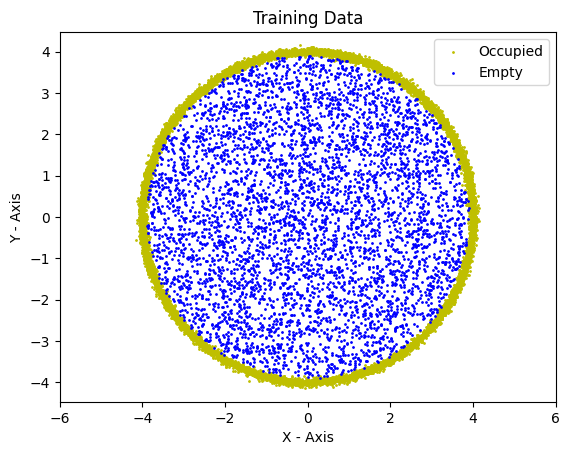

In [1003]:
plt.scatter(
    x=data["occ_lidar_x"],
    y=data["occ_lidar_y"],
    c="y",
    label="Occupied",
    s=1
)
plt.scatter(
    x=data["empty_lidar_x"],
    y=data["empty_lidar_y"],
    c="b",
    label="Empty",
    s=1
)
plt.axis("equal")
plt.xlim(WORLD_SIZE[0], WORLD_SIZE[1])
plt.ylim(WORLD_SIZE[2], WORLD_SIZE[3])
plt.title("Training Data")
plt.xlabel("X - Axis")
plt.ylabel("Y - Axis")
plt.legend()


#### Initialize the Occupancy Grid Mapper

In [1004]:
OGM_CONFIG: dict = {
    "axis_resolution": 0.1, # meters
    "decision_thresholds": [-0.99, 0.99],
    "device": "cuda:0" if torch.cuda.is_available() else "cpu",
    "length_scale": 0.2,
    "quadrant_hierarchy": [1],
    "use_query_normalization": True,
    "use_query_rescaling": False,
    "verbose": True,
    "vsa_dimensions": 2 ** 15,
    "plotting": {
        "plot_xy_voxels": False
    }
}

OGM_CONFIG = DictConfig(OGM_CONFIG)

Building quadrant hierarchy...


Building Quadrant Hierarchy:   0%|          | 0/1 [00:00<?, ?it/s]

Building quadrant level [0]...
Quadrant Level [0] - Number of Quadrants: 1
Quadrant Level [0] - Quadrant Size (Bins): 120, 120
Quadrant Level [0] - Quadrant Size (Meters): 12.0, 12.0
Quadrant Level [0] - Level Size (Bins): 120, 120
Quadrant Level [0] - Level Size (Meters): 12.0, 12.0
Finished building quadrant level [0].
Plotting quadrant centers and quadrants...


Building Quadrant Hierarchy: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Finished plotting quadrant centers and quadrants.
Finished building quadrant hierarchy.
Building quadrant memory hierarchy...
Finished building quadrant memory hierarchy.
Building quadrant indices...
Finished building quadrant indices.
Building XY axis linspace...
Finished building XY axis linspace.
Building XY axis vectors...
Finished building XY axis vectors.
Building XY axis matrix...


X Linspace: 100%|██████████| 120/120 [00:02<00:00, 40.01it/s]


Finished building XY axis matrix.
Building XY axis heatmaps...
Finished building XY axis heatmaps.
Building XY axis class matrices...
Finished building XY axis class matrices.


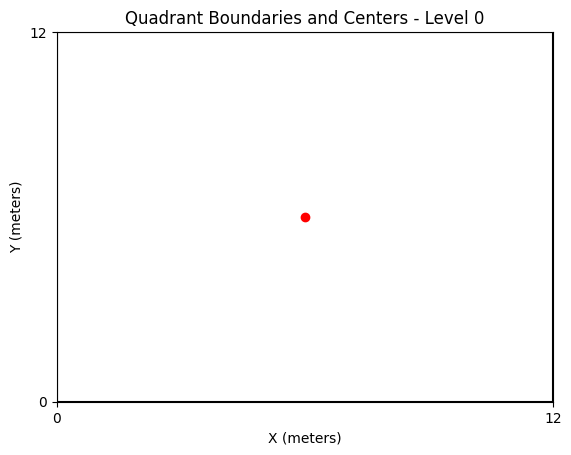

In [1005]:
log_dir = "/home/ssnyde9/dev/highfrost/highfrost/ogm/notebooks/ablation/scratch"
os.makedirs(log_dir, exist_ok=True)

mapper = OGM2D_V4(
    config=OGM_CONFIG,
    world_size=WORLD_SIZE,
    log_dir=log_dir
)

#### Preprocess the training data to match the data structure supported by the mapper

In [1006]:
occ_points = np.zeros(shape=(data["occ_lidar_x"].shape[0], 2))
occ_points[:, 0] = data["occ_lidar_x"]
occ_points[:, 1] = data["occ_lidar_y"]
occ_labels = np.ones(shape=(occ_points.shape[0]))

empty_points = np.zeros(shape=(data["empty_lidar_x"].shape[0], 2))
empty_points[:, 0] = data["empty_lidar_x"]
empty_points[:, 1] = data["empty_lidar_y"]
empty_labels = np.zeros(shape=(empty_points.shape[0]))

point_cloud = np.concatenate((occ_points, empty_points))
labels = np.concatenate((occ_labels, empty_labels))

print(f"Point Cloud Shape: {point_cloud.shape}")

assert point_cloud.shape[0] == (data["occ_lidar_x"].shape[0] + data["empty_lidar_x"].shape[0])
assert labels.shape[0] == (data["occ_lidar_y"].shape[0] + data["empty_lidar_y"].shape[0])

data_idxs = np.arange(point_cloud.shape[0])

assert np.min(data_idxs) == 0
assert np.max(data_idxs) == (point_cloud.shape[0] - 1)

for _ in range(10):
    np.random.shuffle(data_idxs)

test_size = int(TEST_SIZE * point_cloud.shape[0])

train_idx = data_idxs[test_size:]
test_idx = data_idxs[:test_size]

X_train = point_cloud[train_idx]
X_test = point_cloud[test_idx]
y_train = labels[train_idx]
y_test = labels[test_idx]

assert X_train.shape[0] == (point_cloud.shape[0] - int(TEST_SIZE * point_cloud.shape[0]))
assert X_test.shape[0] == (int(TEST_SIZE * point_cloud.shape[0]))
assert y_train.shape[0] == (point_cloud.shape[0] - int(TEST_SIZE * point_cloud.shape[0]))
assert y_test.shape[0] == (int(TEST_SIZE * point_cloud.shape[0]))

print(f"Train Shape: {X_train.shape}, {y_train.shape}")
print(f"Test Shape: {X_test.shape}, {y_test.shape}")

Point Cloud Shape: (15000, 2)
Train Shape: (13500, 2), (13500,)
Test Shape: (1500, 2), (1500,)


#### Encode the dataset into the mapper

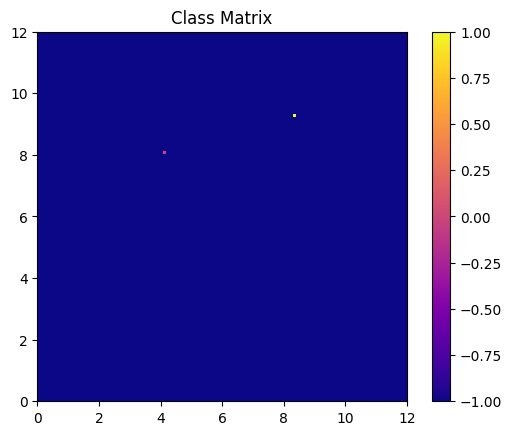

In [1007]:
mapper.process_observation(
    point_cloud=X_train,
    labels=y_train,
)

#### Load the empty and occupied heatmaps

In [1008]:
occupied_hm_path = os.path.join(log_dir, "observations/observation_0/obs_proc/numpy_arrays/occupied_heatmaps.npy")
empty_hm_path = os.path.join(log_dir, "observations/observation_0/obs_proc/numpy_arrays/empty_heatmaps.npy")

occupied_hm = np.load(occupied_hm_path)
empty_hm = np.load(empty_hm_path)

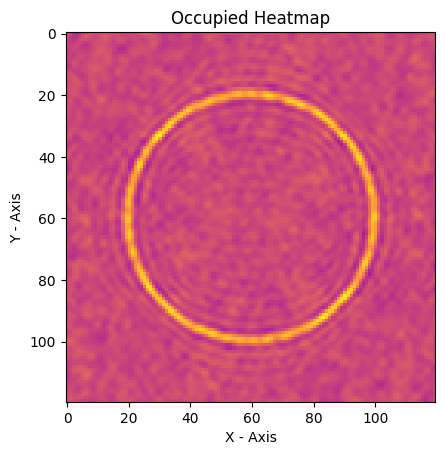

In [1009]:
plt.imshow(occupied_hm, cmap="plasma")
plt.title("Occupied Heatmap")
plt.xlabel("X - Axis")
plt.ylabel("Y - Axis")
plt.clim(-1, 1)

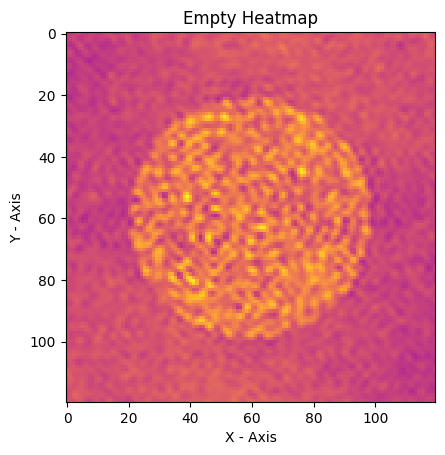

In [1010]:
plt.imshow(empty_hm, cmap="plasma")
plt.title("Empty Heatmap")
plt.xlabel("X - Axis")
plt.ylabel("Y - Axis")
plt.clim(-1, 1)

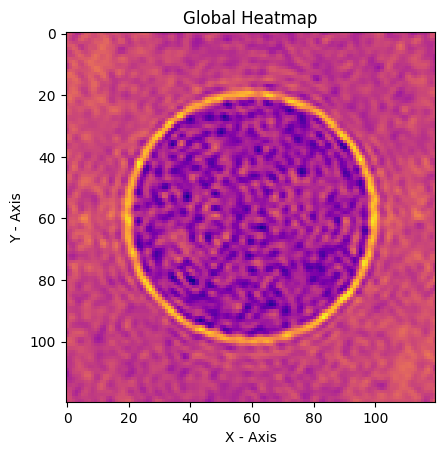

In [1011]:
plt.imshow(occupied_hm - empty_hm, cmap="plasma")
plt.title("Global Heatmap")
plt.xlabel("X - Axis")
plt.ylabel("Y - Axis")
plt.clim(-1, 1)

#### Entropy Parameters

In [1012]:
r_occ = 2.0
r_empty = 2.0

#### Calculate Occupied Entropy

Entropy Min: 0.0
Entropy Max: 3.7004397181410926


Text(0, 0.5, 'Y - Axis')

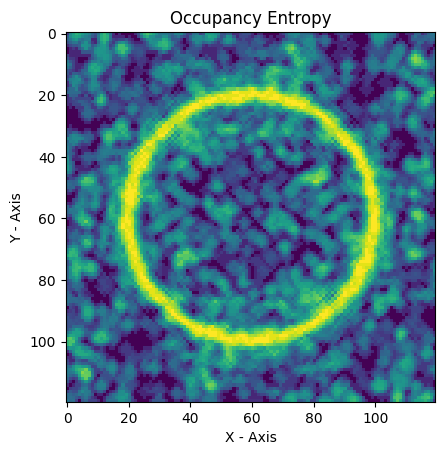

In [1013]:
occ_entropy = np.copy(occupied_hm)
occ_entropy = np.square(occ_entropy)
occ_entropy *= 255
occ_entropy = occ_entropy.astype(np.uint8)
occ_entropy = entropy(occ_entropy, disk(r_occ))

print(f"Entropy Min: {np.min(occ_entropy)}")
print(f"Entropy Max: {np.max(occ_entropy)}")

plt.imshow(occ_entropy)
plt.title("Occupancy Entropy")
plt.xlabel("X - Axis")
plt.ylabel("Y - Axis")

#### Calculate Empty Entropy

Entropy Min: 0.0
Entropy Max: 3.7004397181410926


Text(0, 0.5, 'Y - Axis')

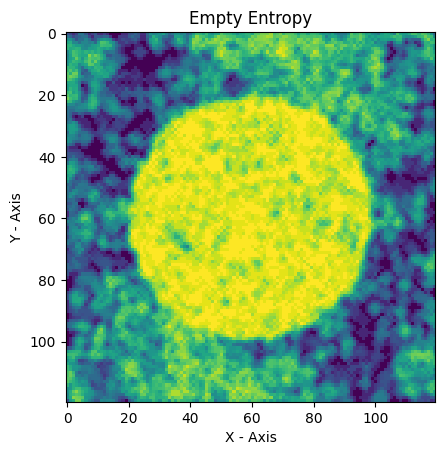

In [1014]:
empty_entropy = np.copy(empty_hm)
empty_entropy = np.square(empty_entropy)
empty_entropy *= 255
empty_entropy = empty_entropy.astype(np.uint8)
empty_entropy = entropy(empty_entropy, disk(r_empty))

print(f"Entropy Min: {np.min(empty_entropy)}")
print(f"Entropy Max: {np.max(empty_entropy)}")

plt.imshow(empty_entropy)
plt.title("Empty Entropy")
plt.xlabel("X - Axis")
plt.ylabel("Y - Axis")

#### Calculate Global Entropy

Entropy Min: -3.7004397181410926
Entropy Max: 3.3927474104487847


Text(0, 0.5, 'Y - Axis')

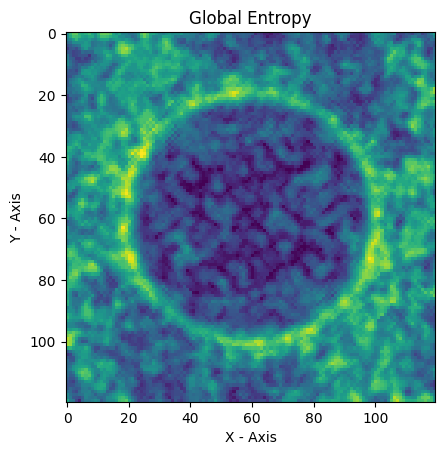

In [1015]:
global_entropy = occ_entropy - empty_entropy

print(f"Entropy Min: {np.min(global_entropy)}")
print(f"Entropy Max: {np.max(global_entropy)}")

plt.imshow(global_entropy)
plt.title("Global Entropy")
plt.xlabel("X - Axis")
plt.ylabel("Y - Axis")

#### Calculate Decision Thresholds

Num Threshold Steps: 710


Text(0, 0.5, 'Threshold Values')

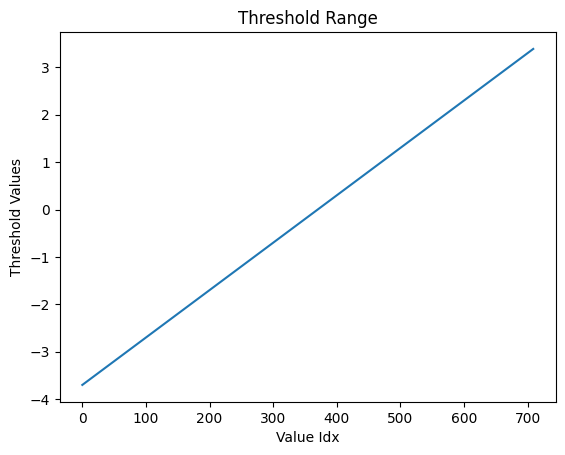

In [1016]:
threshold_min = np.min(global_entropy)
threshold_max = np.max(global_entropy)
threshold_step_size = 0.01
threshold_range = np.arange(threshold_min, threshold_max, threshold_step_size)
print(f"Num Threshold Steps: {threshold_range.shape[0]}")

plt.plot(threshold_range)
plt.title("Threshold Range")
plt.xlabel("Value Idx")
plt.ylabel("Threshold Values")

#### Calculate AUC

In [1017]:
def calculate_preds_w_threshold_test(ge: np.ndarray, threshold: float):
    points = np.copy(X_test)
    labels = np.copy(y_test)

    points = points[points[:,0] >= WORLD_SIZE[0], :]
    points = points[points[:,0] <= WORLD_SIZE[1], :]
    points = points[points[:,1] >= WORLD_SIZE[2], :]
    points = points[points[:,1] <= WORLD_SIZE[3], :]
    labels = labels[points[:,0] >= WORLD_SIZE[0]]
    labels = labels[points[:,0] <= WORLD_SIZE[1]]
    labels = labels[points[:,1] >= WORLD_SIZE[2]]
    labels = labels[points[:,1] <= WORLD_SIZE[3]]  

    assert points.shape[0] == labels.shape[0]
    assert points.shape[0] > 0

    points[:, 0] -= WORLD_SIZE[0]
    points[:, 1] -= WORLD_SIZE[2]
    points /= 0.1
    points = points.astype(np.uint8)

    assert points.shape[0] == labels.shape[0]
    assert points.shape[0] > 0

    e_values = ge[points[:, 1], points[:, 0]]

    assert e_values.shape[0] == points.shape[0]
    
    preds = np.zeros(shape=(points.shape[0]))
    preds[e_values > threshold] = 1

    assert preds.shape[0] == points.shape[0]

    return labels, preds

In [1018]:
y_true: list[np.ndarray] = []
y_pred: list[np.ndarray] = []

for t in threshold_range:
    true, pred = calculate_preds_w_threshold_test(global_entropy, t)
    
    y_true.append(true)
    y_pred.append(pred)

In [1019]:
tpr_list, fpr_list = calculate_multiple_TP_FP_rates(y_true, y_pred)

In [1020]:
auc = metrics.auc(fpr_list, tpr_list)

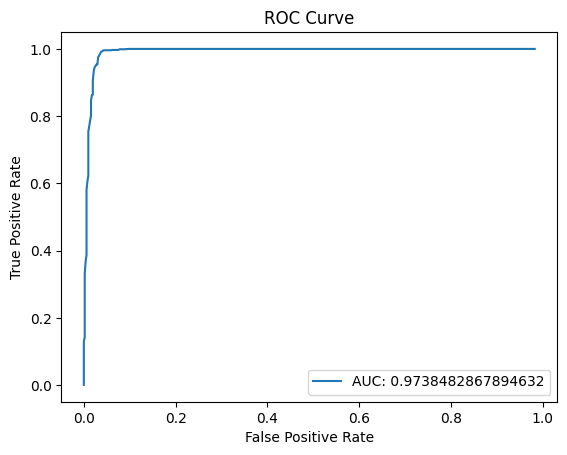

In [1021]:
plt.plot(fpr_list, tpr_list, label=f"AUC: {auc}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("toysim-roc-curve.png", dpi=500)

Best F1 Score: 0.986986986986987
Recall: 0.9959595959595959
Precision: 0.9781746031746031
Best Threshold: -0.26043971814116595


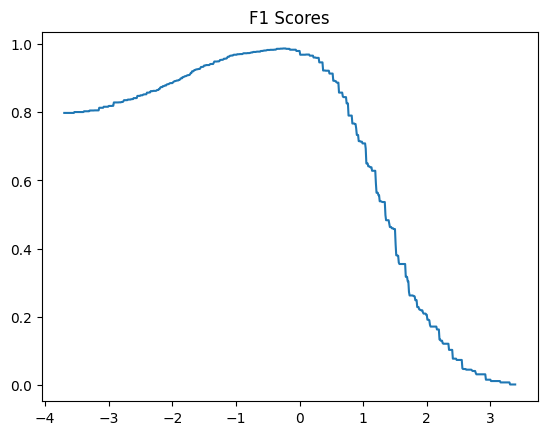

In [1022]:

f1_scores = []
for i in range(len(threshold_range)):
    f1_scores.append(metrics.f1_score(y_true[i], y_pred[i]))

plt.plot(threshold_range, f1_scores)
plt.title("F1 Scores")

best_threshold = threshold_range[np.argmax(f1_scores)]

print(f"Best F1 Score: {np.max(f1_scores)}")

print(f"Recall: {metrics.recall_score(y_true[np.argmax(f1_scores)], y_pred[np.argmax(f1_scores)])}")

print(f"Precision: {metrics.precision_score(y_true[np.argmax(f1_scores)], y_pred[np.argmax(f1_scores)])}")

print(f"Best Threshold: {best_threshold}")


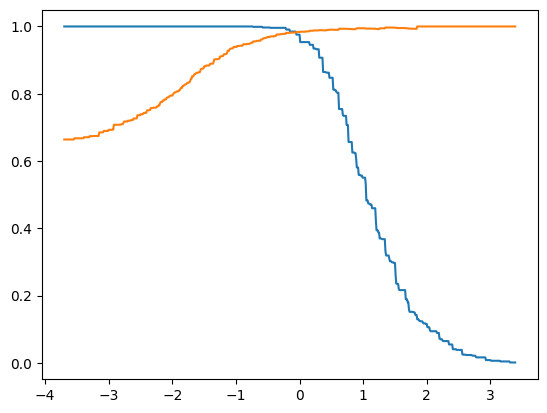

In [1023]:
recall_list = []
precision_list = []

for i in range(len(threshold_range)):
    recall_list.append(metrics.recall_score(y_true[i], y_pred[i]))
    precision_list.append(metrics.precision_score(y_true[i], y_pred[i]))

plt.plot(threshold_range, recall_list, label="Recall")
plt.plot(threshold_range, precision_list, label="Precision")

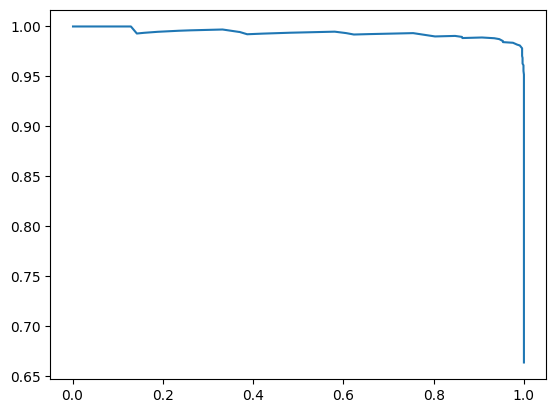

In [1024]:
plt.plot(recall_list[::-1], precision_list[::-1])